# Impermanent Loss
* To download notebook to this tutorial, see [here](https://github.com/defipy-devs/defipy-docs/blob/main/docs/tutorials/imp_loss.ipynb) 

In [37]:
from defipy import *
import numpy as np
import datetime
import matplotlib.pyplot as plt

## Uniswap V2

To determine impermanent loss for Uniswap V2 ($\mathrm{IL_{V2}}$) we apply:

$V_{\rm LP}(\alpha) = 2\,\sqrt{\alpha},$

$V_{H}(\alpha) = 1 + \alpha,$

$\mathrm{IL_{V2}}(\alpha) = \frac{V_{\rm LP}(\alpha)}{V_{H}(\alpha)} - 1 = \frac{2\sqrt{\alpha}}{1+\alpha} - 1.$

where $\alpha = \frac{P_{k}}{P_{0}}$, $V_{\rm LP}$ is the LP position’s value (normalized) and $V_{H}$ is the “HODL” value. 

In [38]:
# Instantiation Parameters
n_steps = 1000     # Number of steps 
start_price = 10 # Initial price SYS/USD
mu = 0.1; sigma = 0.5
n_paths = 1      # Number of simulationed paths
seconds_year = 31536000

# Brownian Model 
bm = BrownianModel(start_price)
p_arr = bm.gen_gbms(mu, sigma, n_steps-1, n_paths).flatten()

dt = datetime.timedelta(seconds=seconds_year/n_steps)
dates = [datetime.datetime.strptime("2024-09-01", '%Y-%m-%d') + k*dt for k in range(n_steps)]

In [39]:
user_nm = 'user0'
tkn1_amount = 1000
tkn2_amount = p_arr[0]*tkn1_amount

tkn1_nm = 'TKN1'
tkn2_nm = 'TKN2'

tkn1 = ERC20('TKN1', "0x111")
tkn2 = ERC20('TKN2', "0x09")
exchg_data = UniswapExchangeData(tkn0 = tkn1, tkn1 = tkn2, symbol="LP", address="0x011")

factory = UniswapFactory("pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, tkn1_amount, tkn2_amount)

lp.summary()

Exchange TKN1-TKN2 (LP)
Reserves: TKN1 = 1000.0, TKN2 = 10000.0
Liquidity: 3162.2776601683795 



In [40]:
out = AddLiquidity().apply(lp, tkn1, user_nm, 10)
lp.summary()

dL = lp.get_last_liquidity_deposit()
iLoss = UniswapImpLoss(lp, dL)

Exchange TKN1-TKN2 (LP)
Reserves: TKN1 = 1010.0, TKN2 = 10100.0
Liquidity: 3193.900436770063 



In [41]:
tkn1_init_amt = iLoss.get_init_amt(tkn1)
tkn2_init_amt = iLoss.get_init_amt(tkn2)
tkn1_hold_amt = iLoss.hold_value(tkn1)
tkn2_hold_amt = iLoss.hold_value(tkn2)

print(f'Initial {tkn1.token_name} amount: {tkn1_init_amt:.2f}, Initial {tkn2.token_name} amount: {tkn2_init_amt:.2f}')
print(f'Hold {tkn1.token_name} amount: {tkn1_hold_amt:.2f}, Hold {tkn2.token_name} amount: {tkn2_hold_amt:.2f}')

Initial TKN1 amount: 10.00, Initial TKN2 amount: 100.00
Hold TKN1 amount: 20.00, Hold TKN2 amount: 200.00


In [42]:
arb = CorrectReserves(lp, x0 = p_arr[0])
TKN_amt = TokenDeltaModel(100)
pTKN1_TKN2_arr = []; 

for k in range(n_steps):

    # *****************************
    # ***** Random Swapping ******
    # *****************************
    Swap().apply(lp, tkn1, user_nm, TKN_amt.delta())
    Swap().apply(lp, tkn2, user_nm, p_arr[k]*TKN_amt.delta())
    
    # *****************************
    # ***** Rebalance ******
    # *****************************
    arb.apply(p_arr[k])

    # *****************************
    # ******* Data Capture ********
    # *****************************
    pTKN1_TKN2_arr.append(LPQuote().get_price(lp, tkn1))

lp.summary()

Exchange TKN1-TKN2 (LP)
Reserves: TKN1 = 1900.275897171504, TKN2 = 9490.982059544718
Liquidity: 3972.077655898381 



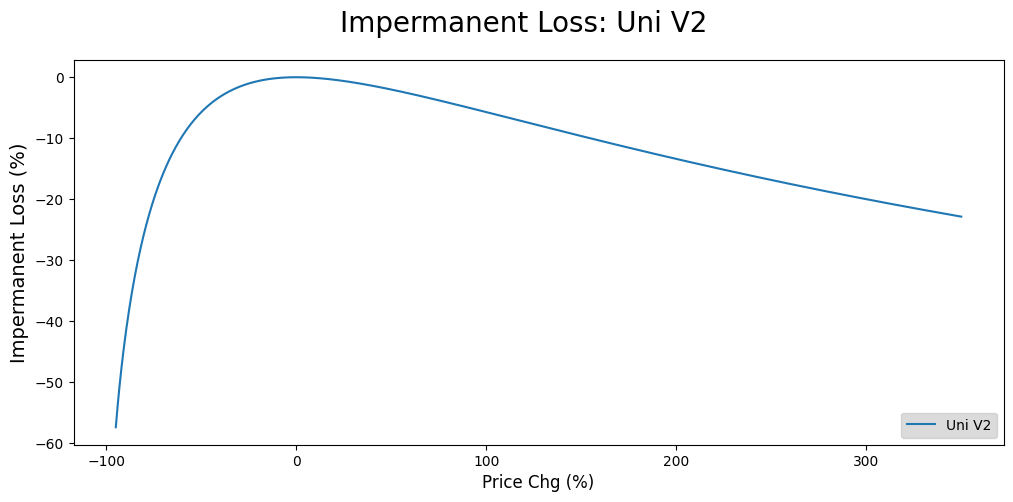

In [43]:
alphas = np.linspace(0, 5, num=n_steps)
alpha_deltas = alphas-1

imp_loss = np.array([iLoss.calc_iloss(alpha) for alpha in alphas])

m0 = 10; m1 = 100
fig, (lp_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 5))
fig.suptitle(f'Impermanent Loss: Uni V2', fontsize=20)
lp_ax.plot(100*alphas[m0:-m1]-100, 100*imp_loss[m0:-m1], label = f'Uni V2') 
lp_ax.set_xlabel("Price Chg (%)", fontsize=12)
lp_ax.set_ylabel("Impermanent Loss (%)", fontsize=14)  
lp_ax.legend(fontsize=10, facecolor="lightgray", loc='lower right')

In [44]:
tkn1_hold_amt = iLoss.hold_value(tkn1)
tkn2_hold_amt = iLoss.hold_value(tkn2)
tkn1_pos_amt = iLoss.current_position_value(tkn1)
tkn2_pos_amt = iLoss.current_position_value(tkn2)

print(f'{tkn1.token_name} hold amt: {tkn1_hold_amt:.2f}, {tkn2.token_name} hold amt: {tkn2_hold_amt:.2f}')
print(f'{tkn1.token_name} position amt: {tkn1_pos_amt:.2f}, {tkn2.token_name} position amt: {tkn2_pos_amt:.2f}')
print(f'Start price: {p_arr[0]:.2f}, End price: {p_arr[-1]:.2f}')

TKN1 hold amt: 30.02, TKN2 hold amt: 149.95
TKN1 position amt: 30.09, TKN2 position amt: 150.30
Start price: 10.00, End price: 4.99


In [45]:
iloss_calc = iLoss.apply(fees = False)
returns_calc = iLoss.apply(fees = True)

print(f'Imp Loss: {100*iloss_calc:.2f}%, returns: {100*returns_calc:.2f} %')

Imp Loss: -5.74%, returns: 0.23 %


## Uniswap V3

To determine impermanent loss for Uniswap V3 as $IL_{V3}(\alpha; r)$, we apply:

$$
IL_{V3}(\alpha; r) =
\begin{cases}
\displaystyle \sqrt{r}\,\alpha - 1, 
& \alpha < \frac{1}{r},
\\[1ex]
\displaystyle \frac{\sqrt{r}}{\sqrt{r}-1}
   \bigl(2\sqrt{\alpha} - (\alpha + 1)\bigr),
& \frac{1}{r} \le \alpha \le r,
\\[1ex]
\displaystyle \sqrt{r}\;-\;\alpha,
& \alpha > r.
\end{cases}
$$

where $\alpha = \frac{P_{k}}{P_{0}}$ and $r = \sqrt{\frac{P_H}{P_L}}$ is the range factor, with $P_L$ and $P_H$ being the lower and upper price bounds chosen for the position.

In [46]:
user_nm = 'user0'
tkn1_amount = 1000
tkn2_amount = p_arr[0]*tkn1_amount

fee = UniV3Utils.FeeAmount.MEDIUM
tick_spacing = UniV3Utils.TICK_SPACINGS[fee]
lwr_tick = UniV3Utils.getMinTick(tick_spacing)
upr_tick = UniV3Utils.getMaxTick(tick_spacing)

In [47]:
tkn1_nm = 'TKN1'
tkn2_nm = 'TKN2'

tkn1 = ERC20(tkn1_nm, "0x09")
tkn2 = ERC20(tkn2_nm, "0x111")

exchg_data = UniswapExchangeData(tkn0 = tkn1, tkn1 = tkn2, symbol="LP",
                                   address="0x011", version = 'V3',
                                   tick_spacing = tick_spacing,
                                   fee = fee)

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

Join().apply(lp, user_nm, tkn1_amount, tkn2_amount, lwr_tick, upr_tick)
lp.summary()

Exchange TKN1-TKN2 (LP)
Real Reserves:   TKN1 = 999.9999999999999, TKN2 = 10000.0
Gross Liquidity: 3162.277660168379 



In [48]:
tick_size = 10000
lwr_tick = UniV3Helper().get_price_tick(lp, -1, lp.get_price(tkn1), tick_size)
upr_tick = UniV3Helper().get_price_tick(lp, 1, lp.get_price(tkn1), tick_size)  
out = AddLiquidity().apply(lp, tkn1, user_nm, 10, lwr_tick, upr_tick)
lp.summary()

dL = lp.last_liquidity_deposit
iLoss = UniswapImpLoss(lp, dL, lwr_tick, upr_tick)

Exchange TKN1-TKN2 (LP)
Real Reserves:   TKN1 = 1009.9999999999999, TKN2 = 10100.262769858964
Gross Liquidity: 3242.81759104987 



In [49]:
tkn1_init_amt = iLoss.get_init_amt(tkn1)
tkn2_init_amt = iLoss.get_init_amt(tkn2)
tkn1_hold_amt = iLoss.hold_value(tkn1)
tkn2_hold_amt = iLoss.hold_value(tkn2)

print(f'Initial {tkn1.token_name} amount: {tkn1_init_amt:.2f}, Initial {tkn2.token_name} amount: {tkn2_init_amt:.2f}')
print(f'Hold {tkn1.token_name} amount: {tkn1_hold_amt:.2f}, Hold {tkn2.token_name} amount: {tkn2_hold_amt:.2f}')

Initial TKN1 amount: 10.00, Initial TKN2 amount: 100.26
Hold TKN1 amount: 20.03, Hold TKN2 amount: 200.26


In [50]:
tick_size = 100000
arb = CorrectReserves(lp, x0 = p_arr[0])
TKN_amt = TokenDeltaModel(100)
pTKN1_TKN2_arr = []; 

for k in range(n_steps):

    # *****************************
    # ***** Random Swapping ******
    # *****************************
    Swap().apply(lp, tkn1, user_nm, TKN_amt.delta())
    Swap().apply(lp, tkn2, user_nm, p_arr[k]*TKN_amt.delta())
    
    # *****************************
    # ***** Rebalance ******
    # *****************************

    lwr_tick = UniV3Helper().get_price_tick(lp, -1, lp.get_price(tkn1), tick_size)
    upr_tick = UniV3Helper().get_price_tick(lp, 1, lp.get_price(tkn1), tick_size)   
    arb.apply(p_arr[k], lwr_tick, upr_tick)

    # *****************************
    # ******* Data Capture ********
    # *****************************
    pTKN1_TKN2_arr.append(LPQuote().get_price(lp, tkn1))

lp.summary()

Exchange TKN1-TKN2 (LP)
Real Reserves:   TKN1 = 1897.6882626222277, TKN2 = 9598.67742413941
Gross Liquidity: 4072.31131861843 



In [51]:
tkn1_hold_amt = iLoss.hold_value(tkn1)
tkn2_hold_amt = iLoss.hold_value(tkn2)
tkn1_pos_amt = iLoss.current_position_value(tkn1, lwr_tick, upr_tick)
tkn2_pos_amt = iLoss.current_position_value(tkn2, lwr_tick, upr_tick)

print(f'{tkn1.token_name} hold amt: {tkn1_hold_amt:.2f}, {tkn2.token_name} hold amt: {tkn2_hold_amt:.2f}')
print(f'{tkn1.token_name} position amt: {tkn1_pos_amt:.2f}, {tkn2.token_name} position amt: {tkn2_pos_amt:.2f}')
print(f'Start price: {p_arr[0]:.2f}, End price: {p_arr[-1]:.2f}')

TKN1 hold amt: 30.07, TKN2 hold amt: 150.21
TKN1 position amt: 70.78, TKN2 position amt: 353.54
Start price: 10.00, End price: 4.99


In [52]:
iloss_calc = iLoss.apply(lwr_tick, upr_tick, fees = False)
returns_calc = iLoss.apply(lwr_tick, upr_tick, fees = True)

print(f'Imp Loss: {100*iloss_calc:.2f}%, returns: {100*returns_calc:.2f} %')

Imp Loss: -5.83%, returns: 135.36 %


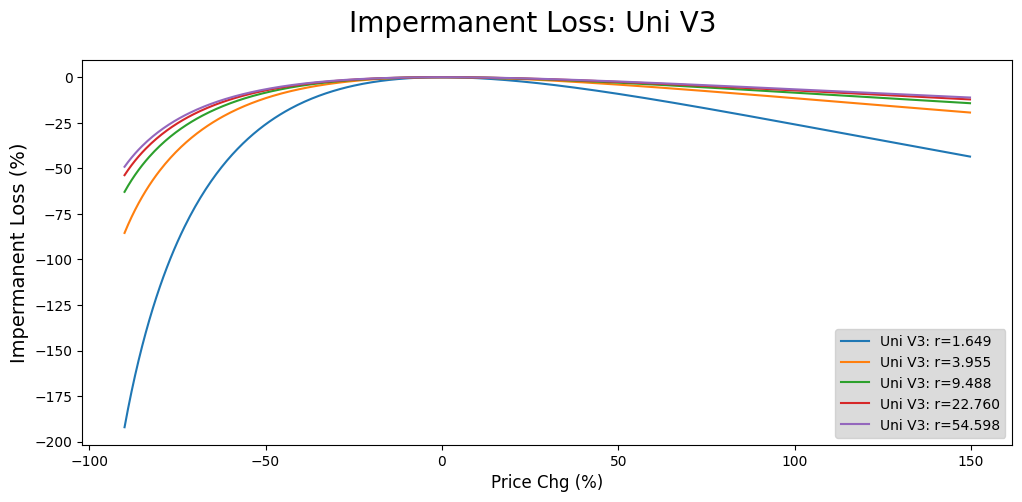

In [53]:
n_steps = 1000
alphas = np.linspace(0, 5, num=n_steps)
alpha_deltas = alphas-1

imp_losses = []
r_arr = np.exp(np.linspace(0.5, 4, num=5))
for r in r_arr: 
    imp_loss = np.array([iLoss.calc_iloss(alpha, r) for alpha in alphas])
    imp_losses.append(imp_loss)

m0 = 20; m1 = 500
fig, (lp_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 5))
fig.suptitle(f'Impermanent Loss: Uni V3', fontsize=20)

for k, imp_loss in enumerate(imp_losses):
    #lp_ax.plot(100*alphas[m0:-m1]-100, 100*imp_loss[m0:-m1]/max(imp_loss[m0:-m1])-1, label = f'Uni V3: r={r_arr[k]:.3f}') 
    lp_ax.plot(100*alphas[m0:-m1]-100, 100*imp_loss[m0:-m1], label = f'Uni V3: r={r_arr[k]:.3f}') 
    lp_ax.set_xlabel("Price Chg (%)", fontsize=12)
    lp_ax.set_ylabel("Impermanent Loss (%)", fontsize=14)  
lp_ax.legend(fontsize=10, facecolor="lightgray", loc='lower right')

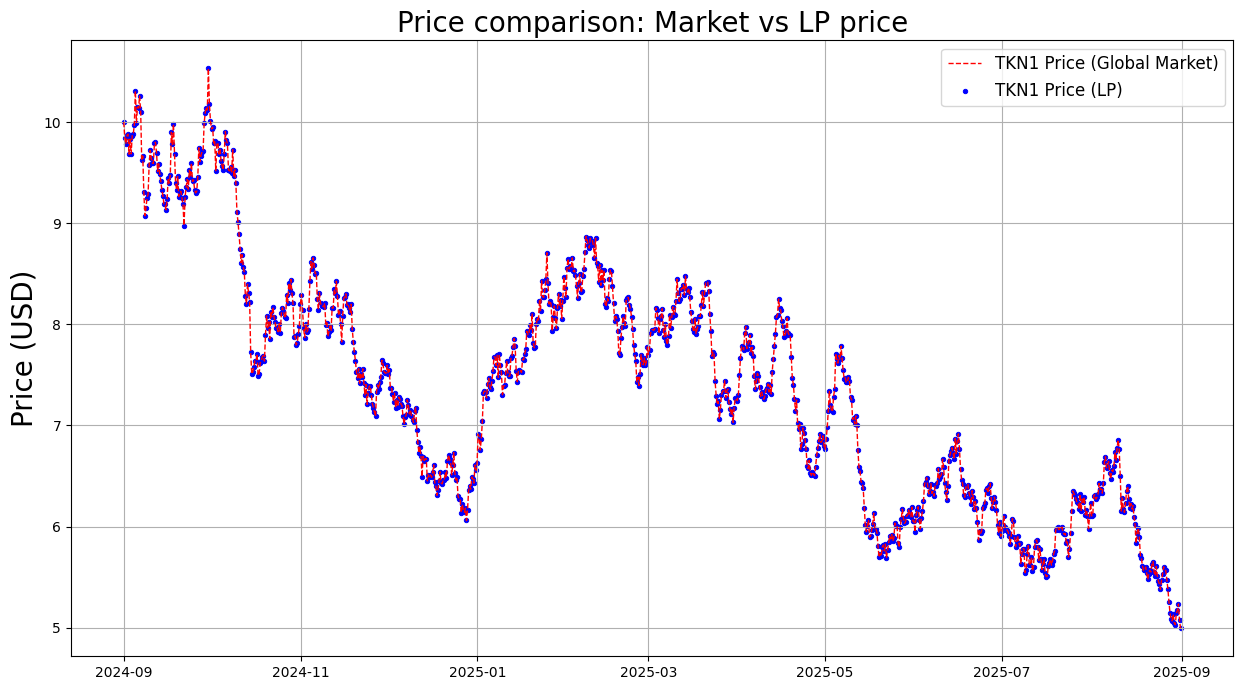

In [54]:
fig, (TKN_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(15, 8))

TKN_ax.plot(dates, p_arr, color = 'r',linestyle = 'dashed', linewidth=1, label=f'{tkn1_nm} Price (Global Market)')
TKN_ax.scatter(dates, pTKN1_TKN2_arr, s=10, marker='o', color = 'b',linestyle = '-', linewidth=0.7, label=f'{tkn1_nm} Price (LP)')

TKN_ax.set_title('Price comparison: Market vs LP price', fontsize=20)
TKN_ax.set_ylabel('Price (USD)', size=20)
TKN_ax.legend(fontsize=12)
TKN_ax.grid()